In [321]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform as sp_rand
from scipy.stats import randint


pd.set_option('display.max_columns', 300)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(palette="Dark2")

In [322]:
"""Calculate RMSE"""
# def rmse(Y, Y_pred, apply_log=False):

#     if apply_log:
#         Z = np.log(Y) - np.log(Y_pred)
#     else:
#         Z = Y - Y_pred

#     return -np.sqrt(np.sum(Z**2)/len(Z))

def rmse(Y, Y_pred):
    Z = Y - Y_pred
    return -np.sqrt(np.sum(Z**2)/len(Z))

def log_rmse(Y, Y_pred):
    Z = np.log(Y) - np.log(Y_pred)
    return -np.sqrt(np.sum(Z**2)/len(Z))

rmse_scorer = make_scorer(rmse)
log_rmse_scorer = make_scorer(log_rmse)


In [323]:
def print_scores_ridge(GS, scorer, X, Y, Bayesian=False):
    if Bayesian:
        print("Best Parms : ", GS.best_params_)    
    else:
        print("Best alpha : ", GS.best_estimator_.alpha)
        
    print("Best R2 Score within CV : ", GS.best_score_)
    print("Best R2 Score on unseen test data", GS.best_estimator_.score(X, Y)) 
    print("Best RMSE Score on unseen test data", scorer(GS.best_estimator_.predict(X),Y))
    
    if(not Bayesian):
        x = GS.cv_results_["mean_test_rmse"]
        min = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][min][0]
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        plt.title("Alpha vs RMSE")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_rmse"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")

        x = GS.cv_results_["mean_test_R2"]
        max = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][max][0]
        plt.subplot(1,2,2)
        plt.title("Alpha vs R2")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_R2"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][max][0], color="orange")
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")
        plt.show()



In [324]:
def get_top_and_bottom_coef(coef, train):
    coef_pd = pd.Series(coef, index = train.columns)
    imp_coef = pd.concat([coef_pd.sort_values().head(10),coef_pd.sort_values().tail(10)])
#     abs_coef = coef_pd.abs().sort_values()
    least_coef = coef_pd.abs().sort_values().head(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

In [325]:
def print_scores_forest(GS, scorer, X, Y, Forest=True):
    rgsr = GS.best_estimator_
    print("Best parms : ", GS.best_params_)
    print("Best regressor : \n", rgsr)

    if(Forest):
        print("OOB Score  : ", rgsr.oob_score_)
    else:
        print("Best R2 score :",rgsr.score(X,Y))
    Y_pred = rgsr.predict(X)
    print("Best RMSE Score on unseen test data:", scorer(Y_pred,Y))
        
    temp = pd.DataFrame({"Prediction":Y_pred, "Actual": Y})
    _ = sns.lmplot(x = "Actual", y =  "Prediction",data = temp, height=8)
    plt.show()

In [326]:
def get_top_and_bottom_features(GS,train):
    rgsr = GS.best_estimator_
#     feature_import = pd.DataFrame(data=regressor.feature_importances_, index=X_scaled.columns.values, columns=['values'])
# feature_import.sort_values(['values'], ascending=False, inplace=True)
# feature_import.transpose()

    coef_pd = pd.Series(rgsr.feature_importances_, index = train.columns).sort_values(ascending=False)
    imp_coef = coef_pd.head(20)
    least_coef = coef_pd.abs().tail(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

# Set 1
Ordinal : Yes <br>
Standardized : Yes

In [327]:
set_num = "set1_"

def create_submission_file(set_str, filename, test_X, pred_Y, log_transform=False):
    sub_data = test_X.copy()
    if log_transform:
        pred_Y = np.exp(pred_Y)
    sub_data["SalePrice"] = pred_Y
    
    sub_data = sub_data[["SalePrice"]]
    
    file = "../data/submission/" + set_str + filename +".csv"
    sub_data.to_csv(file)
        


In [339]:
train_data = pd.read_csv("../data/processed_data/train_processed_set1.csv",index_col=0)
submission_data = pd.read_csv("../data/processed_data/test_processed_set1.csv",index_col=0)

print(train_data.shape)
print(holdout_data.shape)

X = train_data.drop("SalePrice", axis=1)
Y2 = np.log(train_data["SalePrice"])
Y = train_data["SalePrice"]



train_X, test_X, train_Y, test_Y = train_test_split(X, Y,test_size=0.2, random_state=99)
# train_X, test_X, train_Y, test_Y = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1:],test_size=0.2, random_state=99)

train_X2, test_X2, train_Y2, test_Y2 = train_test_split(X, Y2,test_size=0.2, random_state=99)



print("\n")
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

print("\n")
print(train_X2.shape)
print(train_Y2.shape)
print(test_X2.shape)
print(test_Y2.shape)


(1460, 228)
(1459, 227)


(1168, 227)
(1168,)
(292, 227)
(292,)


(1168, 227)
(1168,)
(292, 227)
(292,)


In [329]:
train_X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,TotalFullBaths,TotalHalfBaths,TotalPorch,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_0,RoofMatl_1,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_0,Heating_1,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_1,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolArea_No,PoolArea_Yes,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
543,0.385702,-0.003565,0.646183,-0.509081,0.881166,0.705361,-0.567016,1.039805,-0.230047,1.681709,0.141836,-0.667428,6.369695,-

In [330]:
train_Y.head()

Id
543     213250
1407    133000
339     202500
18       90000
1314    333168
Name: SalePrice, dtype: int64

In [331]:
train_Y2.head()

Id
543     12.270220
1407    11.798104
339     12.218495
18      11.407565
1314    12.716402
Name: SalePrice, dtype: float64

# Ridge with Y

In [332]:
estimator = Ridge(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
grid_search.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  274.5563527054108
Best R2 Score within CV :  -0.15704426581811276
Best R2 Score on unseen test data 0.8801618706162473
Best RMSE Score on unseen test data -0.1612701052623571


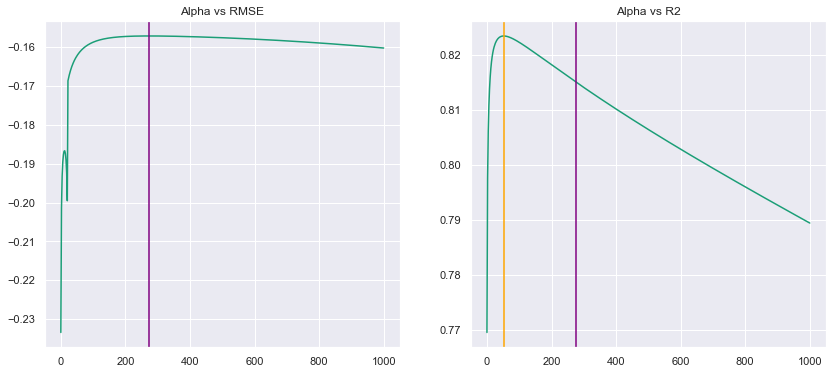

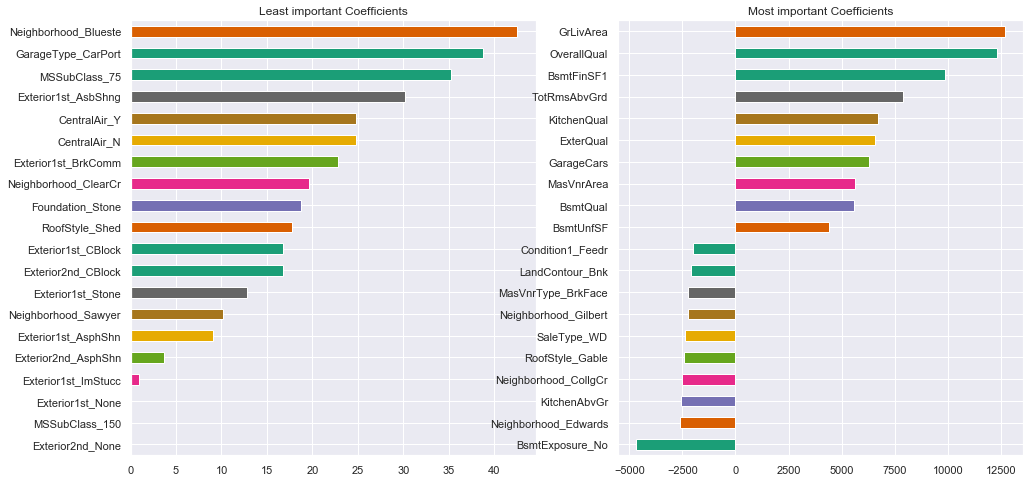

In [333]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [340]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "Ridge", submission_data, pred_Y, log_transform=False)

# Ridge with log(Y)

In [345]:
# estimator = Ridge(random_state=55, max_iter=2000)
# cvs = 5
# param_grid = [
#     {'alpha': np.linspace(1e-2,1e3,500)}
# ]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
grid_search.fit(train_X2, train_Y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  28.06583166332665
Best R2 Score within CV :  -0.13849712375046747
Best R2 Score on unseen test data 0.9119668063531867
Best RMSE Score on unseen test data -0.10676266157149028


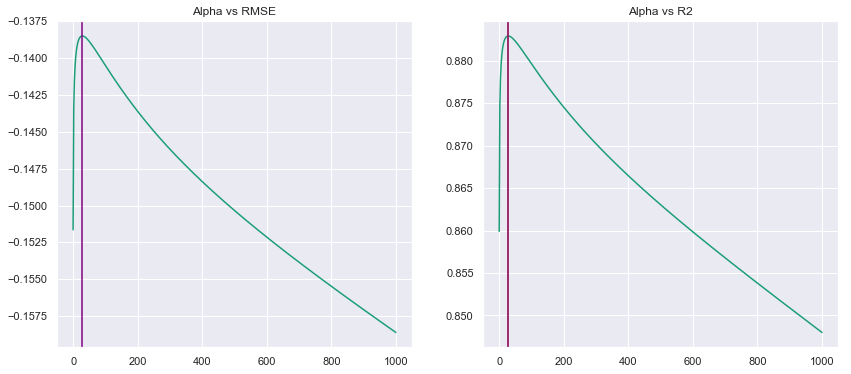

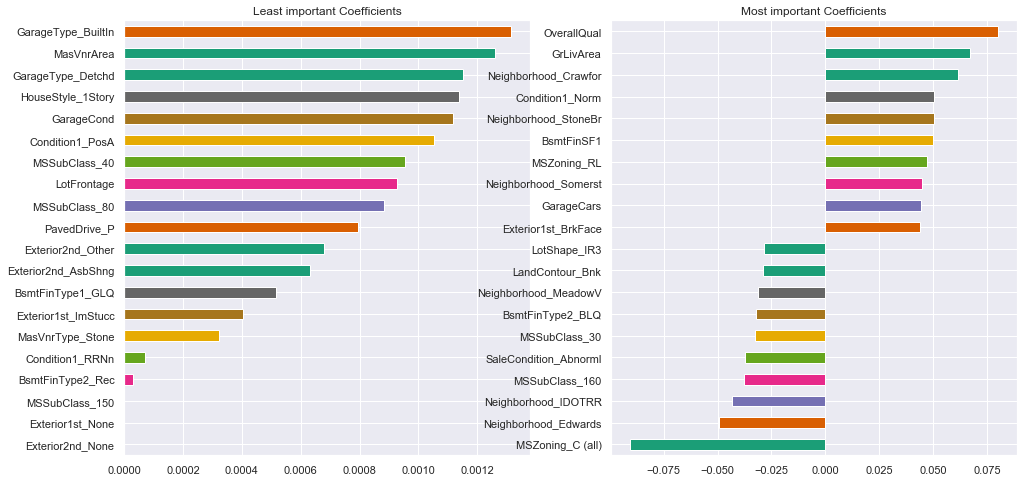

In [346]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [347]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "Ridge_Log", submission_data, pred_Y, log_transform=True)

# Lasso with Y

In [348]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
grid_search.fit(train_X, train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=55,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  308.62414829659315
Best R2 Score within CV :  -0.16155985489628713
Best R2 Score on unseen test data 0.8936350424848212
Best RMSE Score on unseen test data -0.15667324854993064


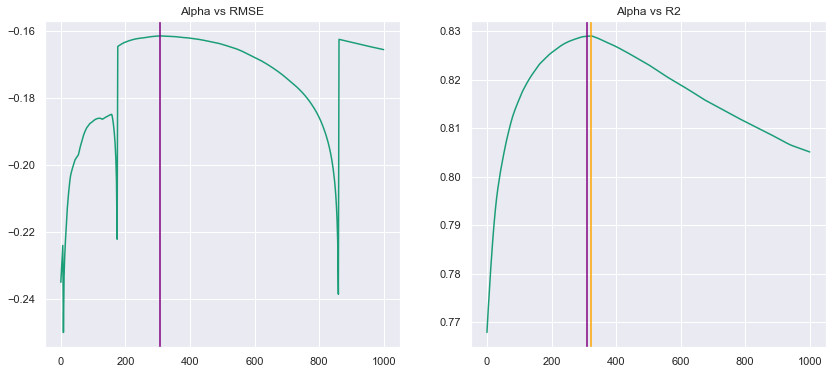

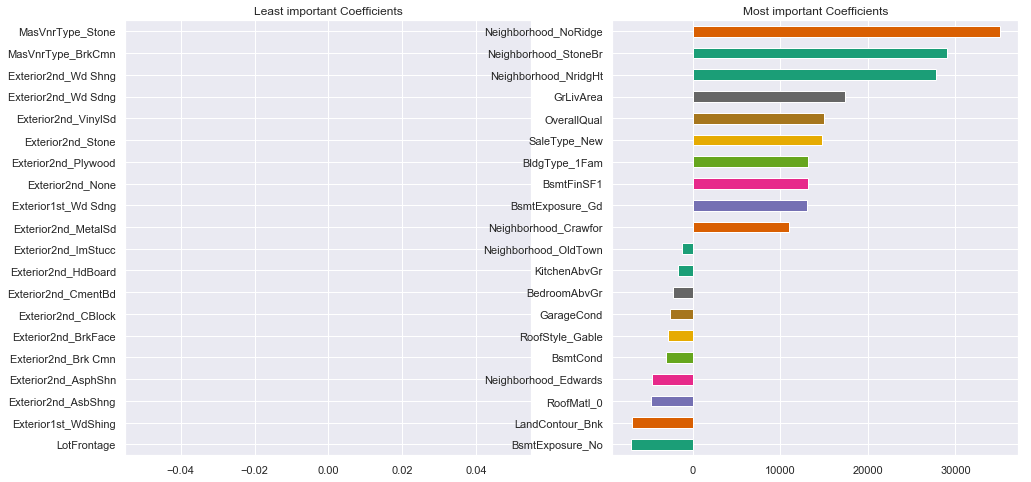

In [349]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [350]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "Lasso", submission_data, pred_Y, log_transform=False)

# Lasso with log(Y)

In [351]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-4,1e2,200)}
]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
grid_search.fit(train_X2, train_Y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=55,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-04, 5.02612e-01, ..., 9.94975e+01, 1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.0001
Best R2 Score within CV :  -0.14491248169024573
Best R2 Score on unseen test data 0.8891582336256254
Best RMSE Score on unseen test data -0.11979753514990109


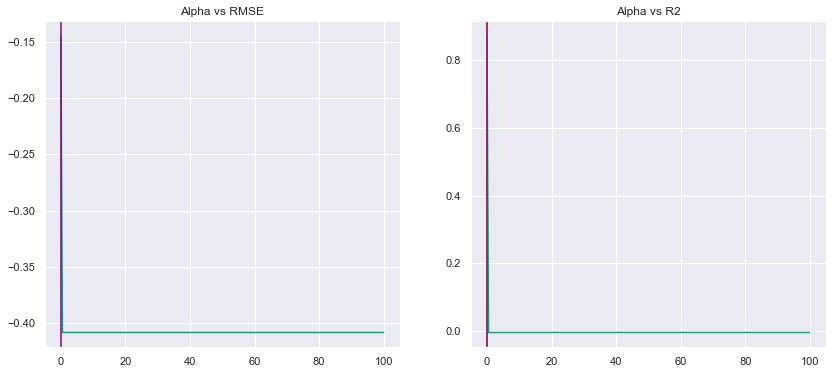

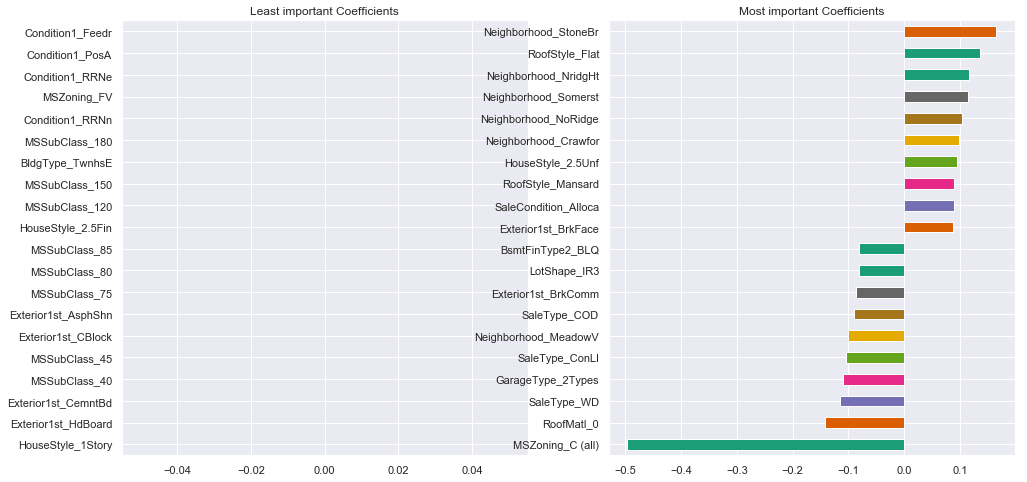

In [352]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [353]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "Lasso_log", submission_data, pred_Y, log_transform=True)

# ElasticNet with Y

In [354]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e1,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.23 s, sys: 90 ms, total: 2.32 s
Wall time: 30.2 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([ 0.01   ,  0.53579,  1.06158,  1.58737,  2.11316,  2.63895,
        3.16474,  3.69053,  4.21632,  4.74211,  5.26789,  5.79368,
        6.31947,  6.84526,  7.37105,  7.89684,  8.42263,  8.94842,
        9.47421, 10.     ]), 'l1_ratio': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.5357894736842106
Best R2 Score within CV :  -0.1570471517360423
Best R2 Score on unseen test data 0.8764652846629454
Best RMSE Score on unseen test data -0.1605692114229543


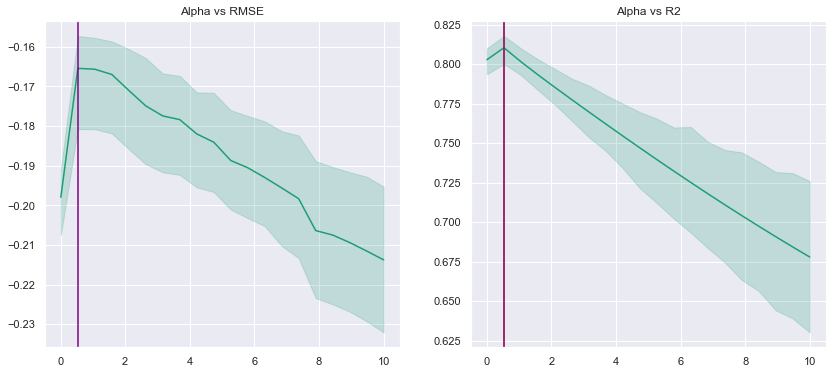

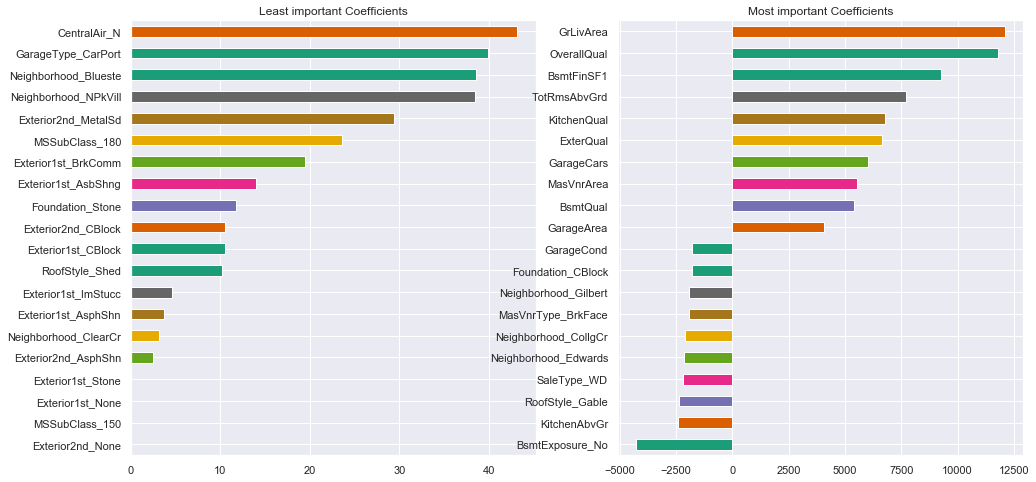

In [356]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [358]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "ENet", submission_data, pred_Y, log_transform=False)

# ElasticNet with Y - Using RandomizedSearchCV for faster search

In [359]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = {
    'alpha': np.linspace(1e-4,1e-2,200),
    "l1_ratio" : sp_rand()
    }

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_distributions=param_grid ,cv=cvs, scoring=custom_scoring, n_iter=50,n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 989 ms, sys: 49.5 ms, total: 1.04 s
Wall time: 19.6 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha': array([0.0001 , 0.00015, ..., 0.00995, 0.01   ]), 'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1a969080>},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.00915427135678392
Best R2 Score within CV :  -0.1877077884299494
Best R2 Score on unseen test data 0.8875489228121433
Best RMSE Score on unseen test data -0.1497006346326219


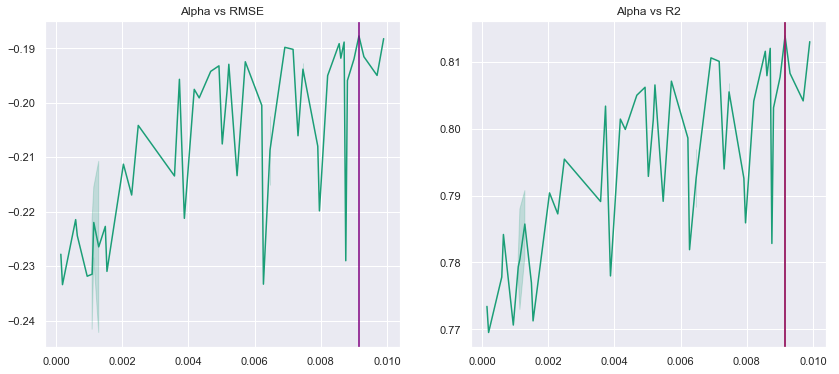

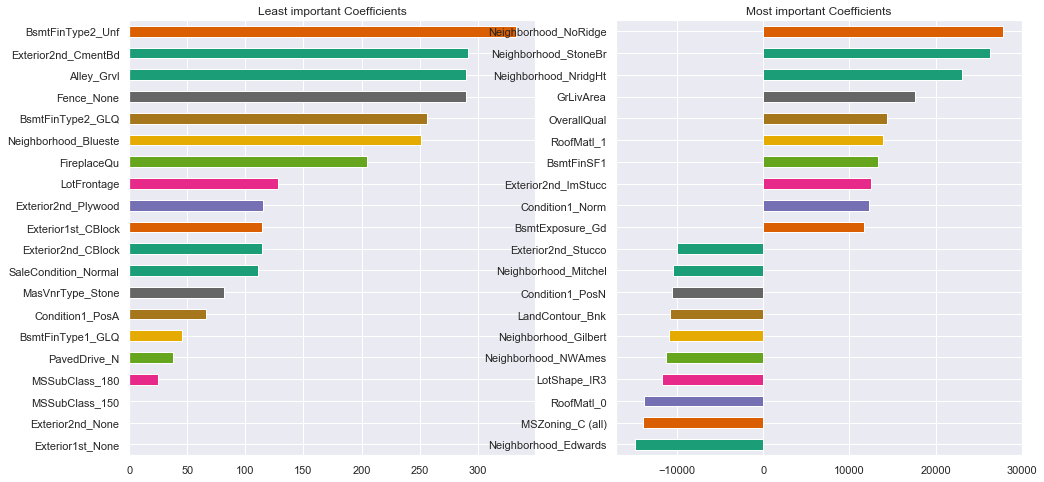

In [360]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [361]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "ENet2", submission_data, pred_Y, log_transform=False)

# ElasticNet with log(Y)

In [362]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = [
    {'alpha': np.linspace(1e-4,1e-2,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 2.9 s, sys: 126 ms, total: 3.03 s
Wall time: 41.4 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([0.0001 , 0.00062, 0.00114, 0.00166, 0.00218, 0.00271, 0.00323,
       0.00375, 0.00427, 0.00479, 0.00531, 0.00583, 0.00635, 0.00687,
       0.00739, 0.00792, 0.00844, 0.00896, 0.00948, 0.01   ]), 'l1_ratio': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.0011421052631578948
Best R2 Score within CV :  -0.13473055673776374
Best R2 Score on unseen test data 0.9319424747429312
Best RMSE Score on unseen test data -0.11295324931317927


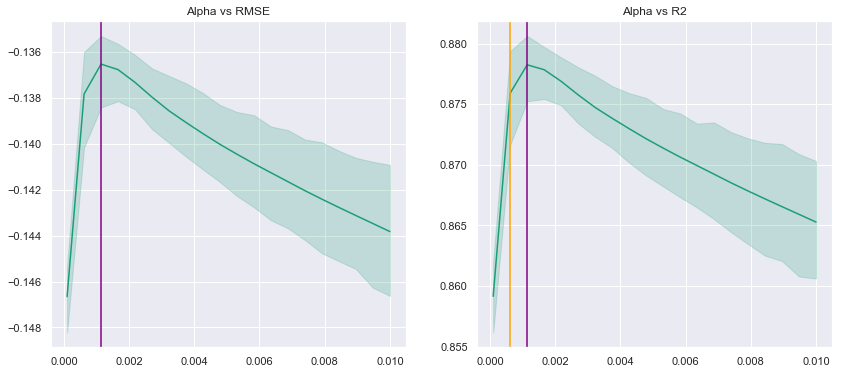

In [28]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X2)

In [363]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "ENet_Log", submission_data, pred_Y, log_transform=True)

# ElasticNet with log(Y) - Using RandomizedSearchCV for faster search

In [364]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = {
    'alpha': np.linspace(1e-4,1e-2,200),
    "l1_ratio" : np.linspace(0,1,100)
    }


custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid ,cv=cvs,n_iter=100, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 628 ms, sys: 22.9 ms, total: 651 ms
Wall time: 5.38 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'alpha': array([0.0001 , 0.00015, ..., 0.00995, 0.01   ]), 'l1_ratio': array([0.    , 0.0101, ..., 0.9899, 1.    ])},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  0.0008959798994974875
Best R2 Score within CV :  -0.1355503514338888
Best R2 Score on unseen test data 0.906278523241258
Best RMSE Score on unseen test data -0.11015791949440587


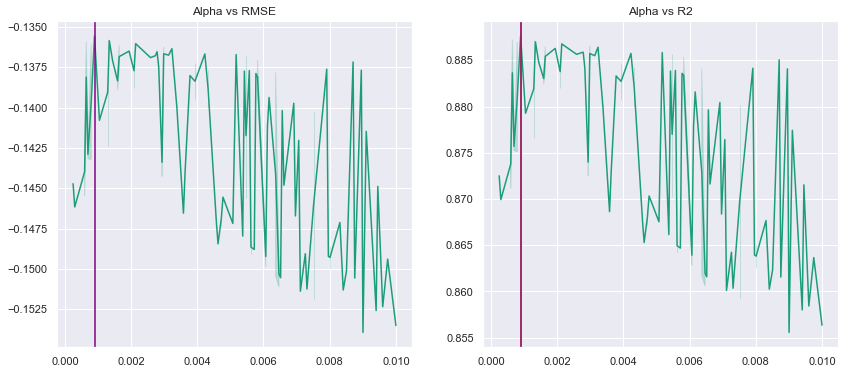

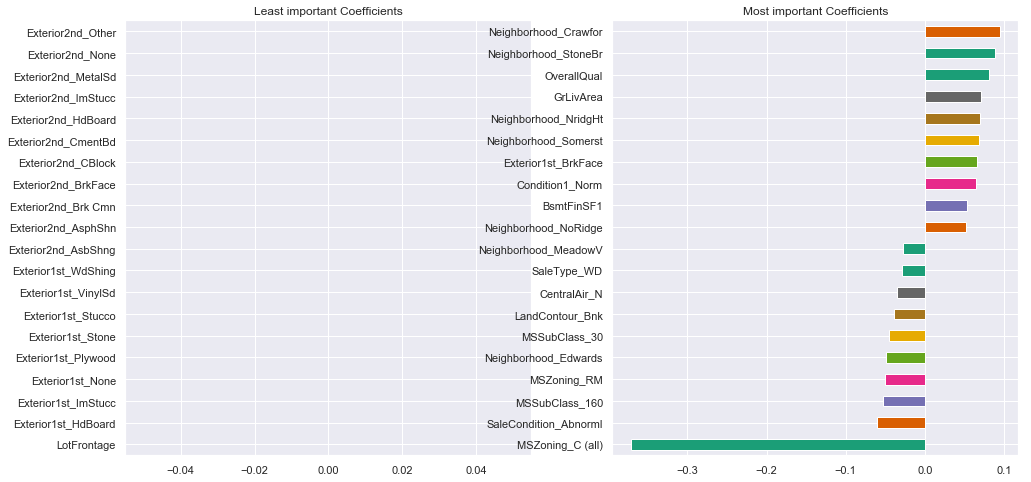

In [365]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [366]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "ENet_Log2", submission_data, pred_Y, log_transform=True)

# Bayesian Ridge with Y

In [375]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : "neg_mean_squared_error", "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X, train_Y)

CPU times: user 459 ms, sys: 27 ms, total: 486 ms
Wall time: 4.35 s


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'alpha_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': 'neg_mean_squared_error', 'R2': 'r2'},
          verbose=0)

Best Parms :  {'lambda_2': 100.0, 'lambda_1': 0.01, 'alpha_2': 0.1, 'alpha_1': 0.001}
Best R2 Score within CV :  -1184058757.7430546
Best R2 Score on unseen test data 0.8909122090478834
Best RMSE Score on unseen test data -0.1494744901541398


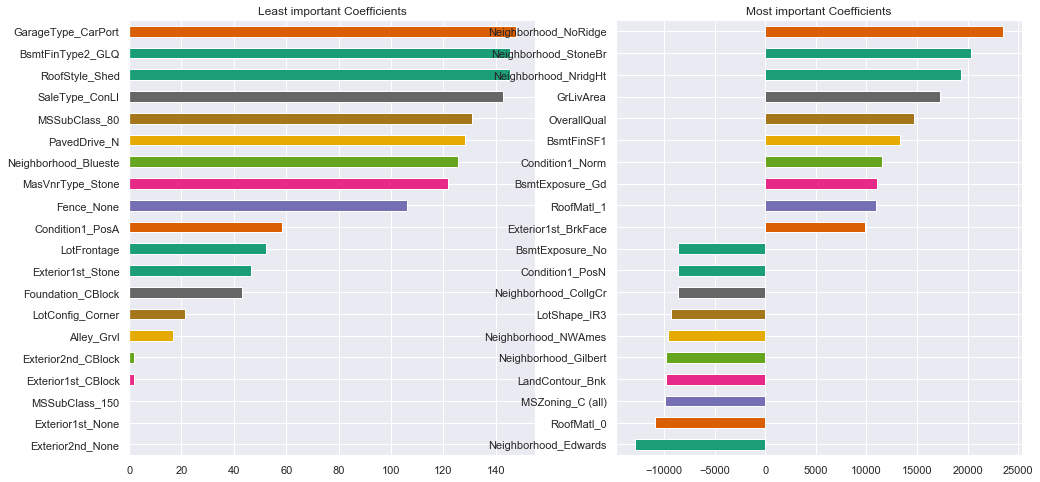

In [376]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [369]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "BayRidge", submission_data, pred_Y, log_transform=False)

# Bayesian Ridge with log(Y)

In [377]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 803 ms, sys: 41.7 ms, total: 845 ms
Wall time: 3.87 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'alpha_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best Parms :  {'lambda_2': 0.01, 'lambda_1': 0.01, 'alpha_2': 10.0, 'alpha_1': 0.0001}
Best R2 Score within CV :  -0.13859928765629537
Best R2 Score on unseen test data 0.9123305774029605
Best RMSE Score on unseen test data -0.10654185071742643


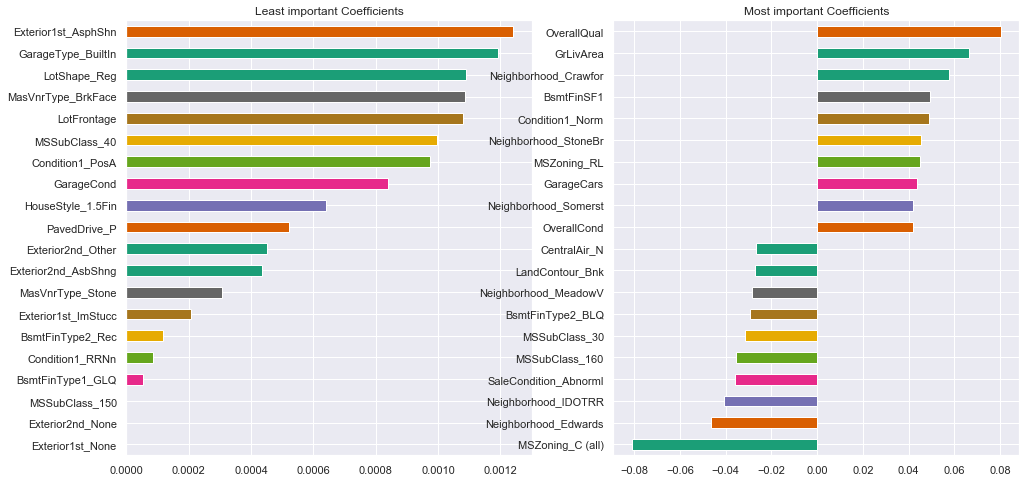

In [378]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [372]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
create_submission_file(set_num, "BayRidge_Log", submission_data, pred_Y, log_transform=True)

# Randomforest with Y 

In [179]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100)
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.26 s, sys: 130 ms, total: 2.39 s
Wall time: 1min 10s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bf1f9b0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f496c88>, 'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best parms :  {'max_depth': 17, 'max_features': 0.2, 'n_estimators': 80}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.84378614425478
Best RMSE Score on unseen test data: -0.12061678634829598


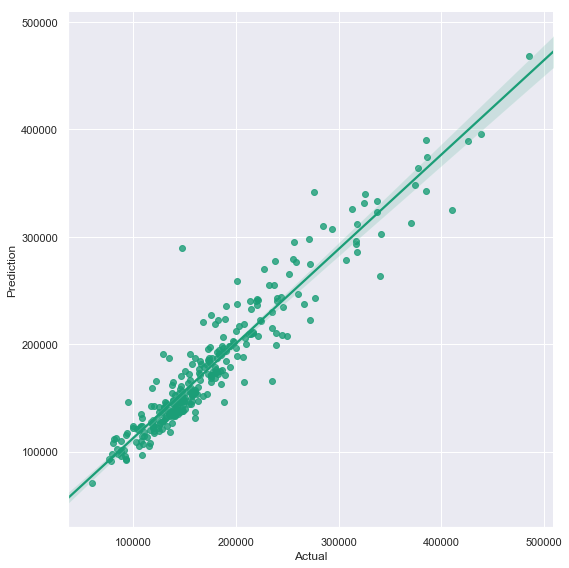

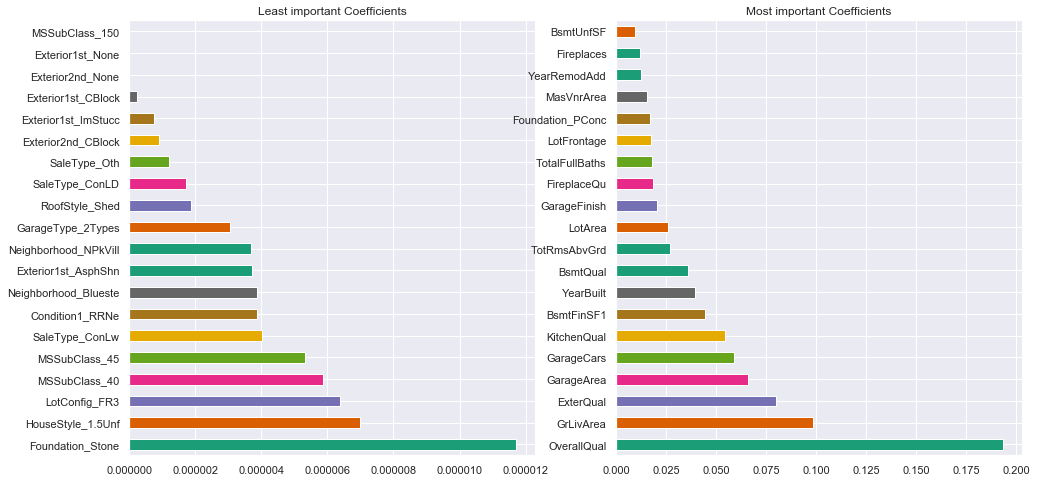

In [181]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

# Randomforest with Y - Using Grid Search to override MSE with Log RMSE

In [182]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto",]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 4.01 s, sys: 138 ms, total: 4.15 s
Wall time: 2min 15s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1fb672e8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f8c8d30>, 'max_features': ['auto']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 94}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=94, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8326889384198763
Best RMSE Score on unseen test data: -0.1176433968743912


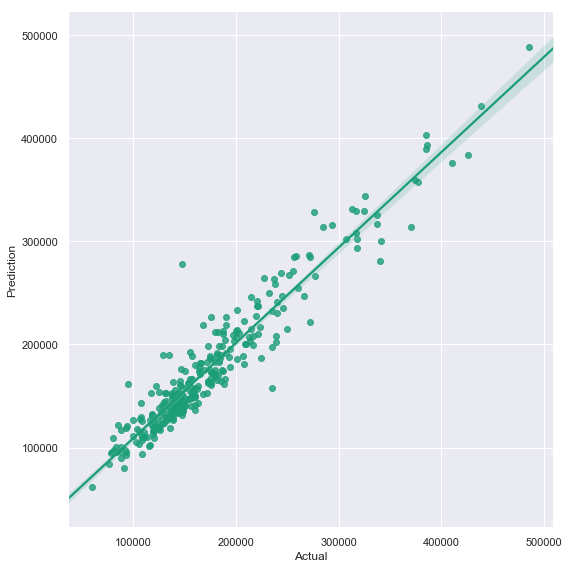

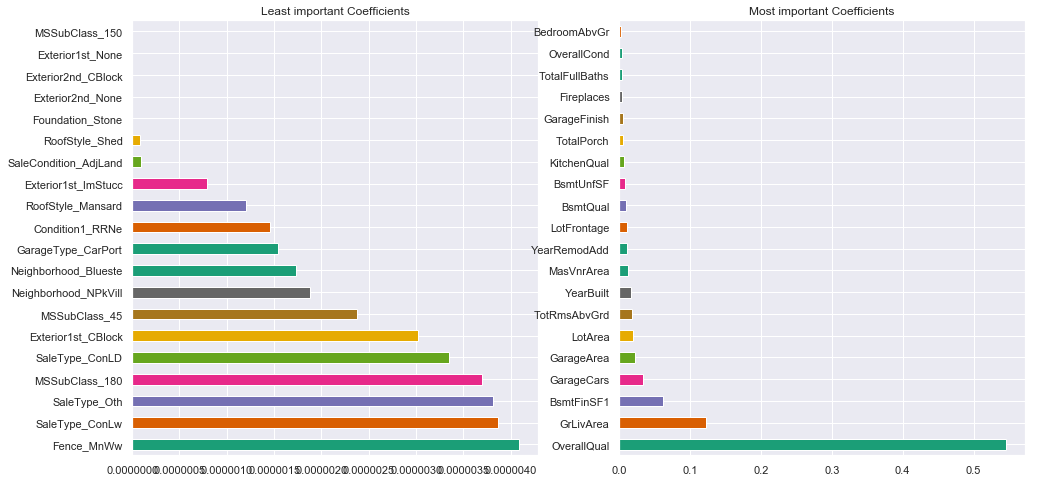

In [183]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

# Randomforest with log(Y) - Using Grid Search to override MSE with Log RMSE

In [184]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 3.23 s, sys: 142 ms, total: 3.37 s
Wall time: 1min 12s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a214bacc0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f8ee940>, 'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 43, 'max_features': 0.2, 'n_estimators': 99}
Best regressor : 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=43,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=99, n_jobs=None,
           oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.870061906932697
Best RMSE Score on unseen test data: -0.1285702662510491


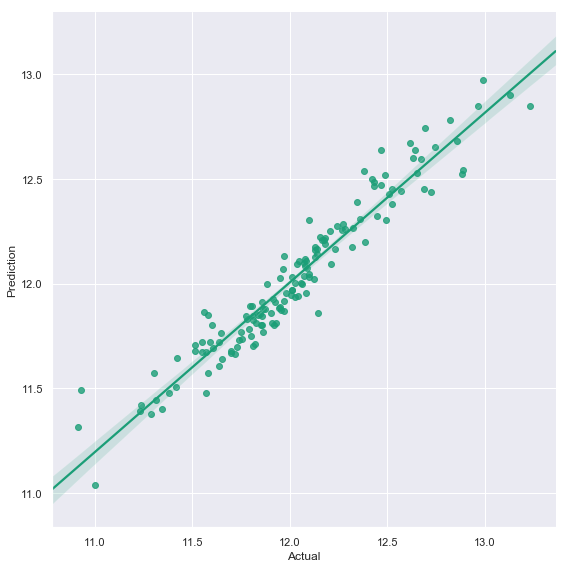

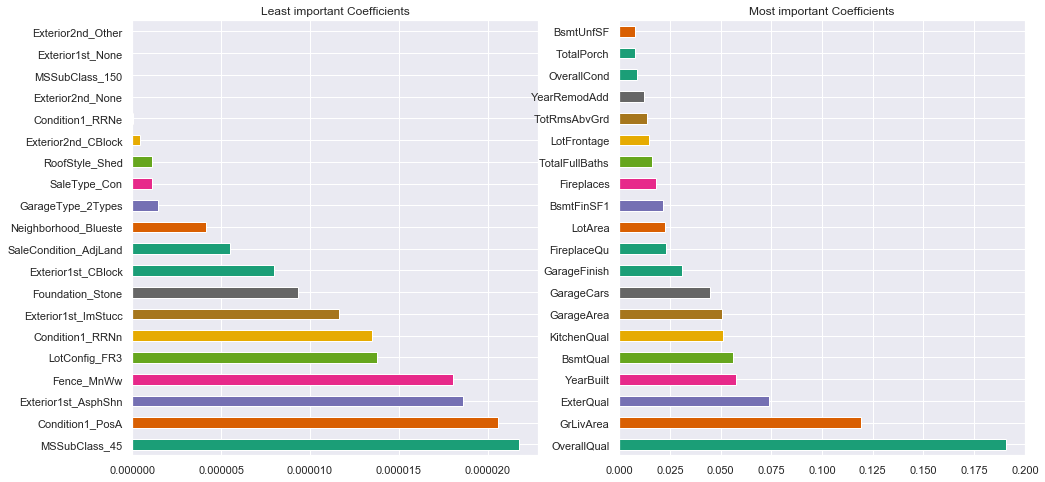

In [185]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

# ExtraTrees with Y - Using Grid Search to override MSE with Log RMSE

In [170]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.13 s, sys: 126 ms, total: 2.26 s
Wall time: 1min 27s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a200a1b70>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a203d79b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best parms :  {'max_depth': 15, 'n_estimators': 18}
Best regressor : 
 ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8096004696779695
Best RMSE Score on unseen test data: -0.13208774669893864


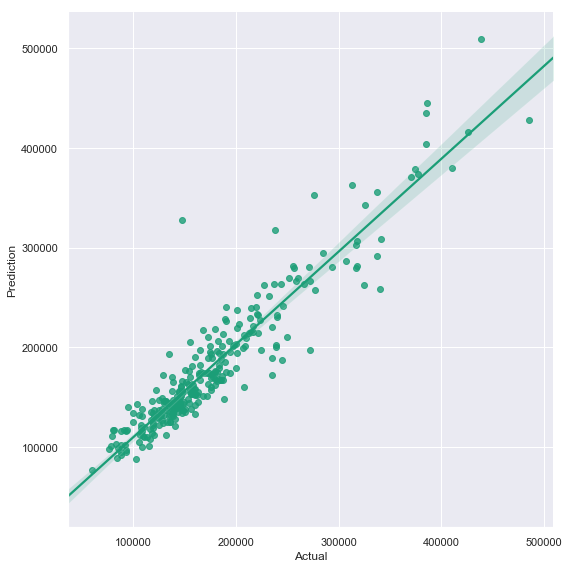

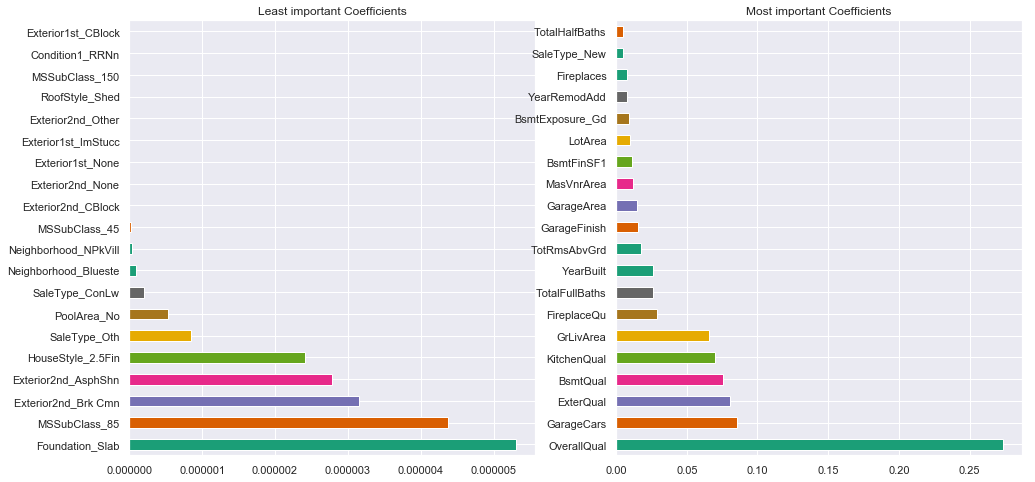

In [171]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

# ExtraTrees with log(Y) - Using Grid Search to override MSE with Log RMSE

In [186]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 3.7 s, sys: 153 ms, total: 3.85 s
Wall time: 1min 54s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f55f6d8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1fe14400>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 20, 'n_estimators': 83}
Best regressor : 
 ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=20,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=83, n_jobs=None,
          oob_score=True, random_state=55, verbose=0, warm_start=False)
OOB Score  :  0.8626005256168501
Best RMSE Score on unseen test data: -0.12813994536201045


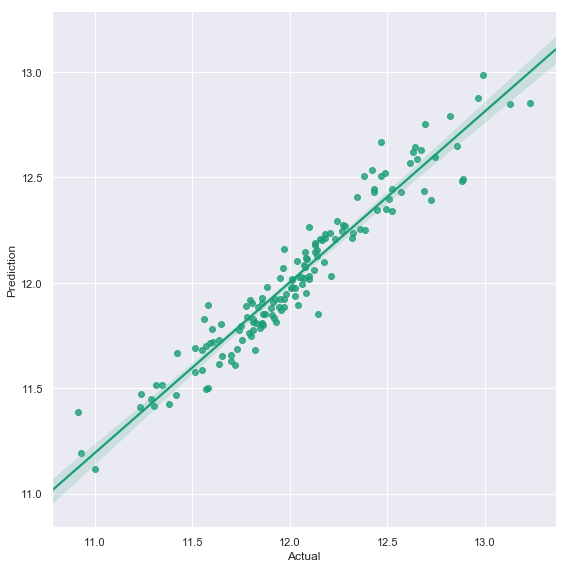

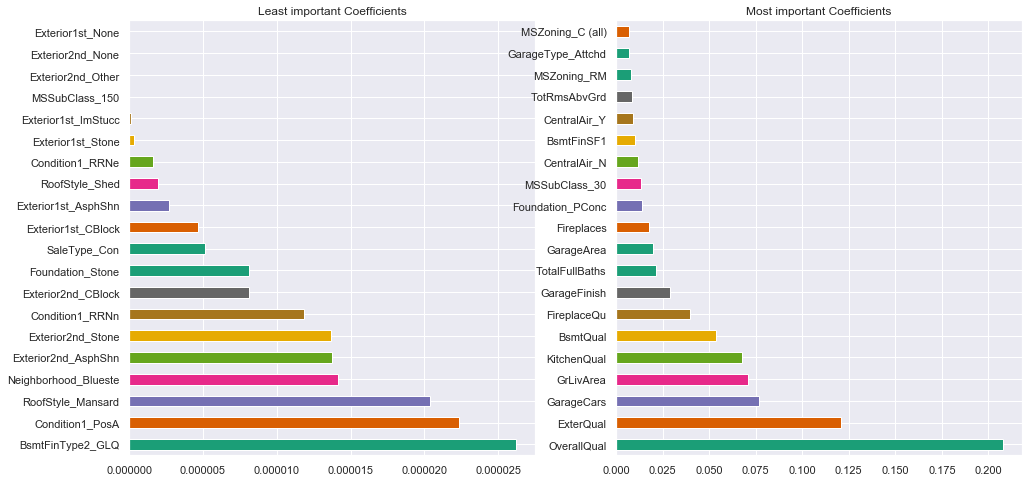

In [187]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

# GradientBoost with Y

In [214]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.48 s, sys: 112 ms, total: 2.6 s
Wall time: 3min 20s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20186a58>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21394cf8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 6, 'n_estimators': 136}
Best regressor : 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=136, n_iter_no_change=None, presort='auto',
             random_state=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Best R2 score : 0.9103907287736216
Best RMSE Score on unseen test data: -0.11258593258157905


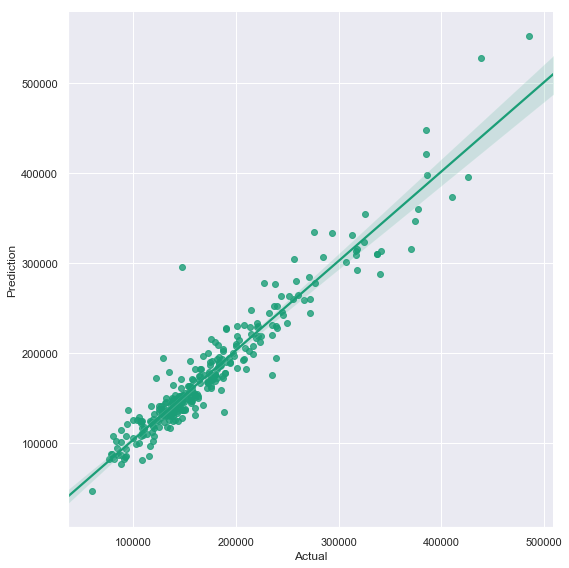

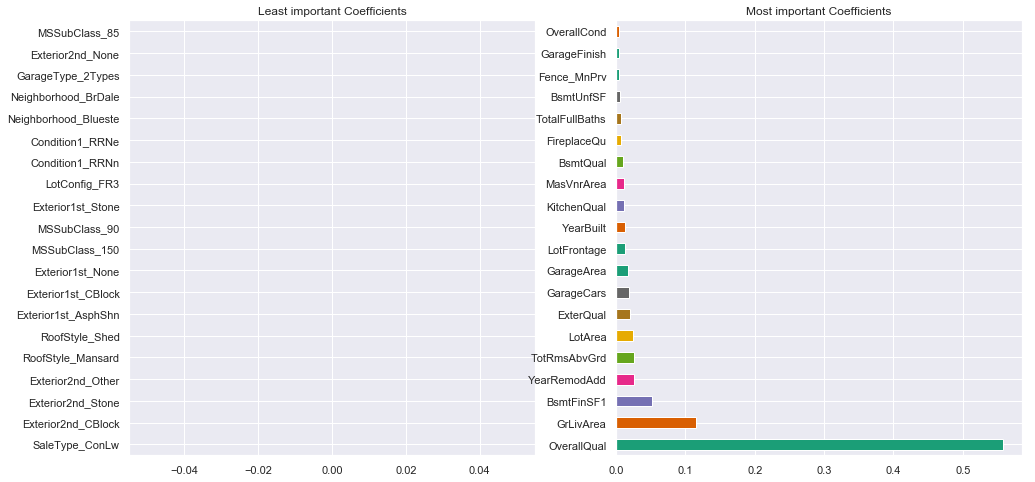

In [217]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

# GradientBoost with log(Y)

In [190]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 2.8 s, sys: 19.1 ms, total: 2.82 s
Wall time: 1min 1s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a208b5320>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a214fb0f0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

Best parms :  {'max_depth': 7, 'n_estimators': 127}
Best regressor : 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=127, n_iter_no_change=None, presort='auto',
             random_state=55, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Best R2 score : 0.9140835957674461
Best RMSE Score on unseen test data: -0.126910834135887


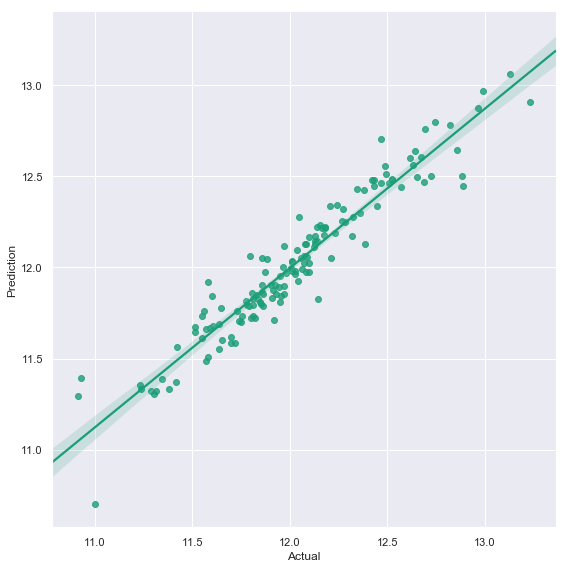

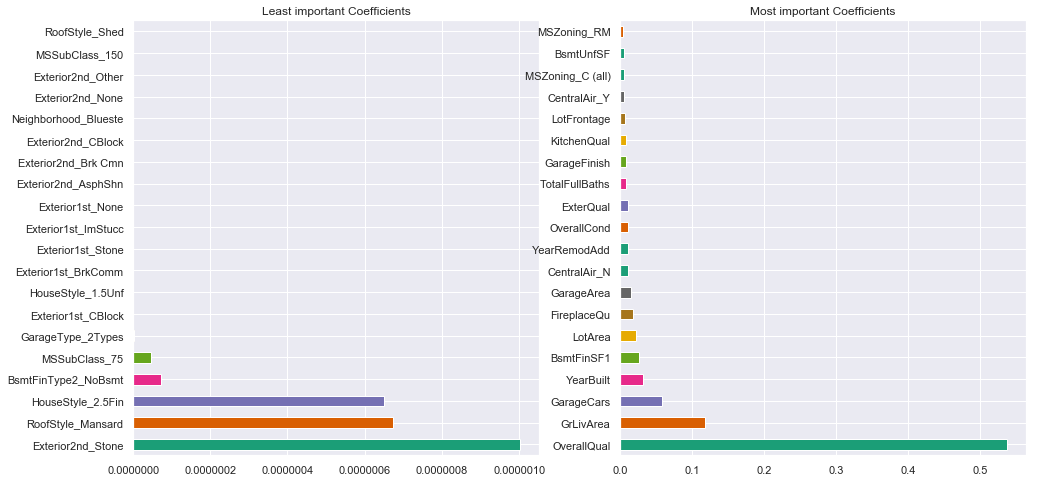

In [213]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

# XGBoost with Y

In [221]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

CPU times: user 2.67 s, sys: 30.8 ms, total: 2.7 s
Wall time: 1min 37s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bd8b1d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a207fe780>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(log_rmse),
          verbose=0)

Best parms :  {'max_depth': 7, 'n_estimators': 98}
Best regressor : 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=98,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best R2 score : 0.9142980202912742
Best RMSE Score on unseen test data: -0.1125261915523118


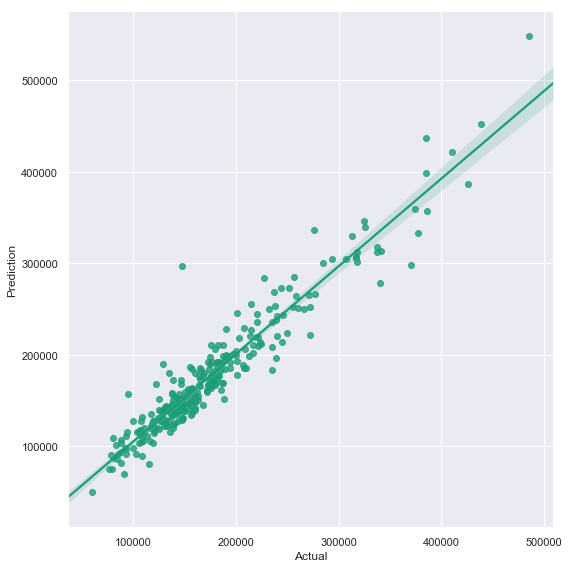

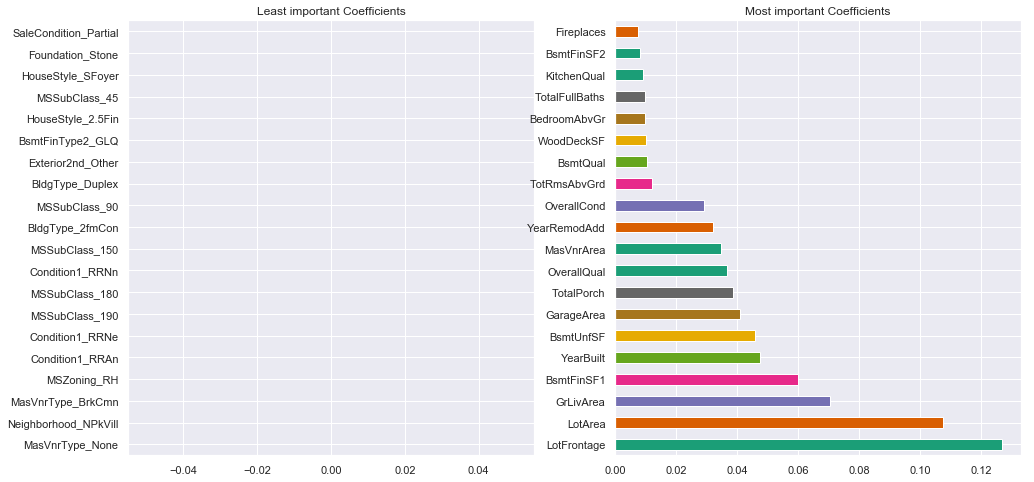

In [222]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

# XGBoost with log(Y)

In [218]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 5.06 s, sys: 52.4 ms, total: 5.11 s
Wall time: 1min 46s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1dfd05f8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1fccde10>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(rmse), verbose=0)

In [ ]:
xgboost.sklearn.XGBModel

Best parms :  {'max_depth': 11, 'n_estimators': 144}
Best regressor : 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=144,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=55,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best R2 score : 0.9310934706498964
Best RMSE Score on unseen test data: -0.11365560034094972


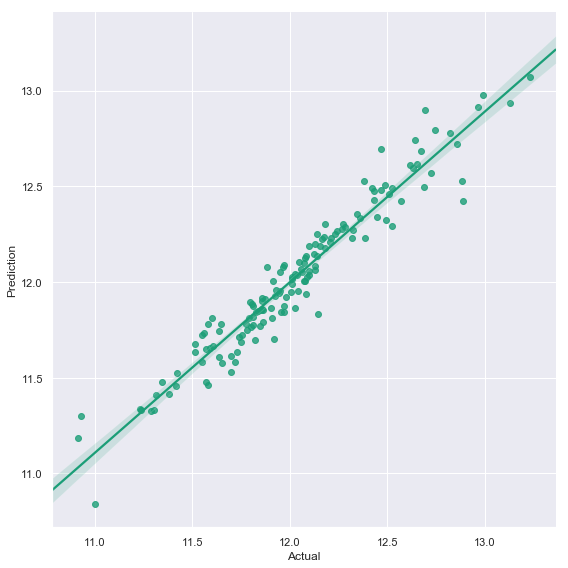

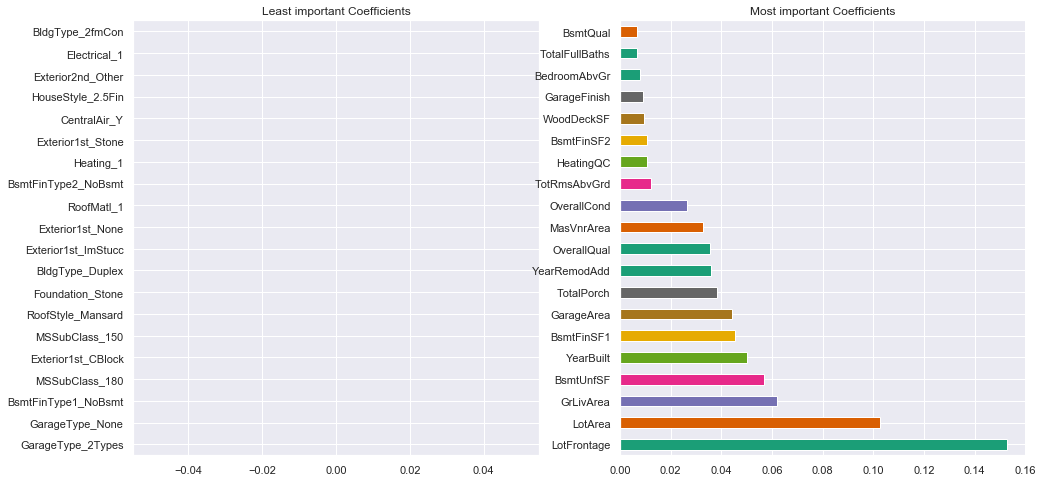

In [219]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

# Bayesian Ridge with log(Y)

CPU times: user 649 ms, sys: 113 ms, total: 761 ms
Wall time: 5.1 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'alpha_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_1': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0], 'lambda_2': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

In [253]:
rgsr = grid_search.best_estimator_
print(rgsr.score(train_X2, train_Y2))
print(rgsr.score(test_X2, test_Y2))
print(rmse(rgsr.predict(test_X2),test_Y2))

0.9173657948633953
0.9094124276128562
-0.10830050310377932


In [237]:
grid_search.best_params_

{'lambda_2': 0.001, 'lambda_1': 0.001, 'alpha_2': 10.0, 'alpha_1': 100.0}